In [ ]:
# importowanie bibliotek i ustawianie formatowania wyświetlania danych
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

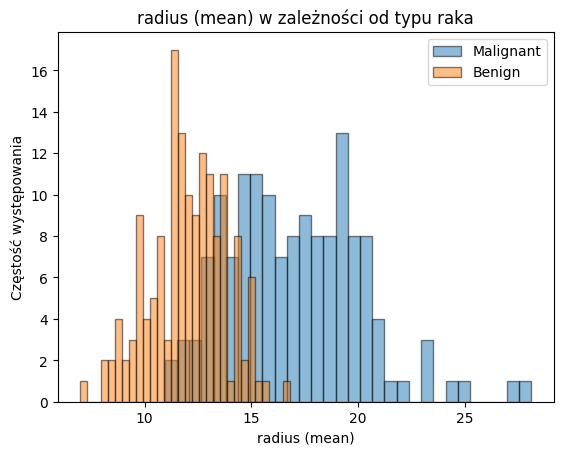

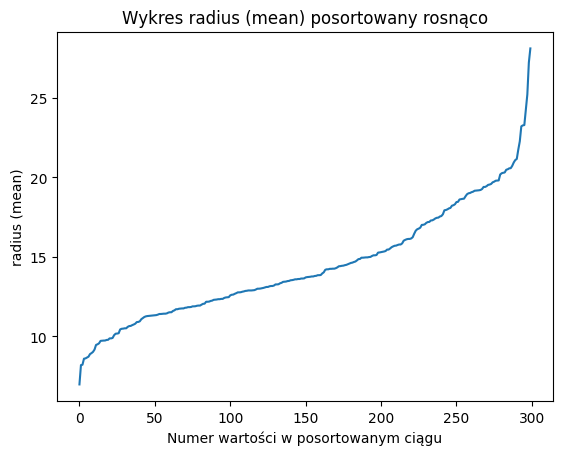

In [ ]:
import scipy.linalg


class CancerAnalysis:
    # zmienne
    breast_labels : list
    breast_train : pd.DataFrame
    breast_validate : pd.DataFrame

    def read_data(self):
        self.breast_labels : pd.DataFrame = pd.io.parsers.read_csv("dataset/breast-cancer.labels", header=None)[0].tolist()
        self.breast_train : pd.DataFrame = pd.io.parsers.read_csv("dataset/breast-cancer-train.dat", header=None)
        self.breast_validate : pd.DataFrame = pd.io.parsers.read_csv("dataset/breast-cancer-validate.dat", header=None)
        self.breast_train.columns = self.breast_labels    # adding labels to data
        self.breast_validate.columns = self.breast_labels    # adding labels to data

    def __feature_hist(self, analyzed_feature : str):
        '''
            Funkcja pomocnicza rysująca histogram zadanej cechy.
        '''
        # Filtrowanie danych dla obu typów
        malignant = self.breast_train[self.breast_train["Malignant/Benign"] == "M"][analyzed_feature]
        benign = self.breast_train[self.breast_train["Malignant/Benign"] == "B"][analyzed_feature]
        # Rysowanie histogramów
        plt.hist(malignant, bins=30, alpha=0.5, label="Malignant", edgecolor='black')
        plt.hist(benign, bins=30, alpha=0.5, label="Benign", edgecolor='black')
        plt.xlabel(analyzed_feature)
        plt.ylabel("Częstość występowania")
        plt.title(f"{analyzed_feature} w zależności od typu raka")
        plt.legend()
        plt.show()
    
    def __feature_plot(self, analyzed_feature : str):
        '''
            Funkcja pomocnicza rysująca wykres zadanej cechy.
        '''
        sorted_feature = self.breast_train[analyzed_feature].sort_values().reset_index(drop=True)   # reset_index przywraca indeksowanie po kolei 
        ax2 = sorted_feature.plot()
        ax2.set_xlabel("Numer wartości w posortowanym ciągu")
        ax2.set_ylabel(analyzed_feature)
        ax2.set_title(f"Wykres {analyzed_feature} posortowany rosnąco")
        plt.show()

    def print_feature_graph(self, analyzed_feature : str = 'radius (mean)'):
        '''
            Można wybrać analizowaną cechę spośród:
            'radius (mean)', 'texture (mean)', 'perimeter (mean)', 'area (mean)', 'smoothness (mean)', 'compactness (mean)', 
            'concavity (mean)', 'concave points (mean)', 'symmetry (mean)', 'fractal dimension (mean)', 'radius (stderr)', 
            'texture (stderr)', 'perimeter (stderr)', 'area (stderr)', 'smoothness (stderr)', 'compactness (stderr)', 
            'concavity (stderr)', 'concave points (stderr)', 'symmetry (stderr)', 'fractal dimension (stderr)', 'radius (worst)', 
            'texture (worst)', 'perimeter (worst)', 'area (worst)', 'smoothness (worst)', 'compactness (worst)', 'concavity (worst)', 
            'concave points (worst)', 'symmetry (worst)', 'fractal dimension (worst)'
        '''
        self.__feature_hist(analyzed_feature)
        self.__feature_plot(analyzed_feature)
    
    def create_linear_matrix(self, df):
        """
        Dla reprezentacji liniowej: wykorzystujemy wszystkie cechy (pomijając 'patient ID' i 'Malignant/Benign').
        Dodajemy kolumnę jedynek jako wyraz wolny.
        """
        X = df.iloc[:, 2:].to_numpy()   # pierwsze dwie kolumny to identyfikator i etykieta
        ones = np.ones((X.shape[0], 1)) # Dodajemy kolumnę jedynek
        A_linear = np.hstack((ones, X))
        return A_linear

    def create_quadratic_matrix(self, df):
        """
        Dla reprezentacji kwadratowej: wybieramy podzbiór cech:
        'radius (mean)', 'perimeter (mean)', 'area (mean)', 'symmetry (mean)'
        i tworzymy macierz, która zawiera kolumnę jedynek, terminy liniowe oraz kwadratowe.
        """
        features = ['radius (mean)', 'perimeter (mean)', 'area (mean)', 'symmetry (mean)']
        X = df[features].to_numpy()
        X_squared = X**2
        ones = np.ones((X.shape[0], 1))
        # Łączymy - stała, liniowa oraz kwadratowa
        A_quadratic = np.hstack((ones, X, X_squared))
        return A_quadratic

    def create_target_vector(self, df):
        """
        Tworzy wektor celu b. Przyjmujemy:
          1  - nowotwór złośliwy (np. kodowany jako 'M')
         -1  - nowotwór łagodny (np. kodowany jako 'B')
        """
        b = np.where(df['Malignant/Benign'] == 'M', 1, -1)
        return b

    def compute_weights(self, A, b):
        """
        Oblicza wagi metodą najmniejszych kwadratów przy użyciu równania normalnego (A^T A) w = A^T b
        """
        ATA = A.T @ A
        ATb = A.T @ b
        weights = np.linalg.solve(ATA, ATb)
        return weights
    
    def compute_weights_SVD(self, A, lambda_coeff, b):
        """
        Oblicza wagi metodą najmniejszych kwadratów przy użyciu równania normalnego (A^T A + λI) w = A^T b
        korzystając z funkcji scipy.linalg.lstsq stosującej rozkład SVD.
        """
        ATA = A.T @ A 
        ATA += lambda_coeff*np.identity(A.shape[1])
        ATb = A.T @ b
        weights = scipy.linalg.lstsq(ATA, ATb)[0]
        return weights

# Tworzenie obiektu klasy
analysis = CancerAnalysis()

# Wczytujemy dane   | a)
analysis.read_data() 

# Wyświetlamy wykres oraz histogram zadanej cechy   | b)
analysis.print_feature_graph("radius (mean)")   # TODO upewnić się że wykres ma tak wyglądać (tak mi się wydaje, na wiki było inaczej ale imo niepoprawnie)

# Macierze liniowe dla zbioru treningowego i walidacyjnego  | c)
A_lin_train = analysis.create_linear_matrix(analysis.breast_train)
A_lin_validate = analysis.create_linear_matrix(analysis.breast_validate)
# Macierze kwadratowe dla zbioru treningowego i walidacyjnego
A_quad_train = analysis.create_quadratic_matrix(analysis.breast_train)
A_quad_validate = analysis.create_quadratic_matrix(analysis.breast_validate)

# Wektor target (b) dla zbioru treningowego | d)
b_train = analysis.create_target_vector(analysis.breast_train) 

# Obliczenie wag metodą najmniejszych kwadratów na zbiorze treningowym  |  e)
weights_linear = analysis.compute_weights(A_lin_train, b_train) 
weights_quadratic = analysis.compute_weights(A_quad_train, b_train)

# Odrębny zbiór wag dla reprezentacji liniowej | f)
weights_linear_SVD = analysis.compute_weights_SVD(A_lin_train, 0.0, b_train)
weights_linear_regularized_SVD = analysis.compute_weights_SVD(A_lin_train, 0.001, b_train)

# Obliczenie współczynnika uwarunkowania macierzy | g)
condition_A_lin_train = np.linalg.cond(A_lin_train)
condition_A_quad_train = np.linalg.cond(A_quad_train)
# Wskaźnik uwarunkowania rośnie wraz ze stopniem wpływu błędu reprezentacji numerycznej na błąd wyniku.
# W szczególności, niski wskaźnik uwarunkowania oznacza, że błąd wyniku jest niski.

# Sprawdzanie trafności przewidywań | h)
# Reprezentacja liniowa
prediction_A_lin_validate = A_lin_validate @ weights_linear
prediction_A_lin_validate_SVD = A_lin_validate @ weights_linear_SVD
prediction_A_lin_validate_regularized_SVD = A_lin_validate @ weights_linear_regularized_SVD
# Reprezentacja kwadratowa
prediction_A_quad_validate = A_quad_validate @ weights_quadratic

# TODO: Porównać otrzymane wektory z wektorem b_validate
b_validate = analysis.create_target_vector(analysis.breast_validate)

# Zaokrąglanie do -1 albo 1 zgodnie z założeniami
round_lambda = lambda x: 1 if x > 0 else -1
prediction_A_lin_validate = round_lambda(prediction_A_lin_validate)
prediction_A_lin_validate_SVD = round_lambda(prediction_A_lin_validate_SVD)
prediction_A_lin_validate_regularized_SVD = round_lambda(prediction_A_lin_validate_regularized_SVD)
prediction_A_quad_validate = round_lambda(prediction_A_quad_validate)

# TODO: Obliczyć macierz pomyłek oraz dokładność metody
# confusion_matrix = ...
# accuracy = ...
